In [15]:
import kagglehub
asdasdasasdas_garbage_classification_path = kagglehub.dataset_download('asdasdasasdas/garbage-classification')

print('Data source import complete.')

100%|██████████| 82.0M/82.0M [00:00<00:00, 100MB/s]

Extracting files...


Data source import complete.


In [29]:
import os
os.listdir(os.path.join(asdasdasasdas_garbage_classification_path, 'Garbage classification', 'Garbage classification'))

['paper', 'cardboard', 'glass', 'metal', 'plastic', 'trash']

In [30]:
Garbage = os.path.join(asdasdasasdas_garbage_classification_path, 'Garbage classification', 'Garbage classification')

In [31]:
import numpy as np
import pandas as pd

In [32]:
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Rescaling, AveragePooling2D
from keras.models import Sequential, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import VGG19, ResNet50
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory ## to import dataset from a directory (where folder name is the class and the files inside the folder are data associated with the class name)

In [35]:
shape=(224, 224, 3)

# Loading the dataset

In [36]:
# training dataset
dataset = image_dataset_from_directory(
    Garbage,
    image_size=(224, 224),  # Resize images to this size (height, width)
    batch_size=32,          # Number of images to return in each batch
    label_mode='categorical',       # Can be "int", "categorical", or "binary" depending on your use case
    shuffle=True,           # Shuffle the data
    seed=123,               # Seed for reproducibility
    validation_split=0.2,   # Percentage of data to reserve for validation
    subset="training"       # Specify 'training' or 'validation' for the split
)

# validation dataset (if using validation split)
validation_dataset = image_dataset_from_directory(
    Garbage,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

# to see the class names
class_names = dataset.class_names
print("Class names:", class_names)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [37]:
NUM_CLASSES = len(dataset.class_names)
NUM_CLASSES

# Checking the default shape of random image

In [14]:
import cv2

image = cv2.imread('/content/drive/MyDrive/Datasets/garbage-classification/garbage_classification/battery/battery3.jpg')
print(image.shape)

(183, 275, 3)


# Visualization

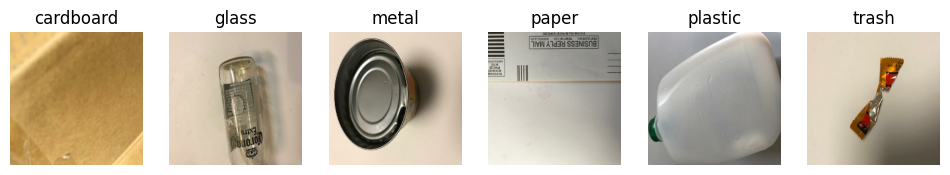

In [81]:
class_names = dataset.class_names

# function to display one image from each label
def display_one_image_from_each_label(dataset, class_names):
    label_dict = {class_name: None for class_name in class_names}  # Dictionary to hold one image for each label

    # Loop through the dataset to find one image from each class
    for images, labels in dataset:
        # Loop through the labels in the batch
        for i, label in enumerate(labels.numpy()):
            class_idx = np.argmax(label)
            class_name = class_names[class_idx]

            if label_dict[class_name] is None:
                label_dict[class_name] = images[i]

        if all(value is not None for value in label_dict.values()):
            break

    # Display one image from each class
    plt.figure(figsize=(12, 8))
    for i, (class_name, img) in enumerate(label_dict.items()):
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img.numpy().astype("uint8"))  # Convert tensor to NumPy array for display
        plt.title(class_name)
        plt.axis('off')

    plt.show()

# Display one image from each label
display_one_image_from_each_label(dataset, class_names)


# Augmentation

In [38]:
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential([
    layers.Input(shape),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

data_augmentation.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 224, 224, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Creating architecture to train

In [47]:
## using CONVOLUTIONAL NEURAL NETWORK ##

model_cnn = Sequential()

model_cnn.add(Input(shape))
model_cnn.add(data_augmentation)
model_cnn.add(Rescaling(1./255))

model_cnn.add(Conv2D(128, (3,3), strides=2, padding='same', activation='relu'))
model_cnn.add(MaxPool2D(2,2))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model_cnn.add(MaxPool2D(2,2))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu'))

model_cnn.add(Flatten())

model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(NUM_CLASSES, activation='softmax'))

model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,945,254 (49.38 MB)

 Trainable params: 12,944,870 (49.38 MB)

 Non-trainable params: 384 (1.50 KB)

In [50]:
opt = Adam(learning_rate=0.00001)
model_cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [51]:
model_cnn.fit(
    dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.4814 - loss: 1.2905 - val_accuracy: 0.2871 - val_loss: 1.8966
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5144 - loss: 1.2253 - val_accuracy: 0.2495 - val_loss: 1.8557
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5522 - loss: 1.1967 - val_accuracy: 0.2495 - val_loss: 1.7883
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5386 - loss: 1.2063 - val_accuracy: 0.2733 - val_loss: 1.6762
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5574 - loss: 1.1698 - val_accuracy: 0.3446 - val_loss: 1.5103
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.5425 - loss: 1.1742 - val_accuracy: 0.4535 - val_loss: 1.3439
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5504 - loss: 1.1437 - val_accuracy: 0.5208 - val_loss: 1.2263
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.5316 - loss: 1.1446 - val_accuracy: 0.5564 - v

In [52]:
model_cnn.evaluate(validation_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6438 - loss: 0.9618


[0.9460366368293762, 0.6356435418128967]

In [53]:
## using VGG19 ##

base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
    classes=NUM_CLASSES,
    pooling='max'
)

base_model.trainable = True

model_vgg19 = Sequential()
model_vgg19.add(Input(shape))
model_vgg19.add(data_augmentation)
model_vgg19.add(Rescaling(1./255))

model_vgg19.add(base_model)
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dense(NUM_CLASSES, activation='softmax'))

model_vgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 20,290,118 (77.40 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
opt = Adam(learning_rate=0.00001)
model_vgg19.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [55]:
model_vgg19.fit(
    dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 671ms/step - accuracy: 0.2997 - loss: 1.6716 - val_accuracy: 0.5782 - val_loss: 1.1506
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 560ms/step - accuracy: 0.6024 - loss: 1.0774 - val_accuracy: 0.7129 - val_loss: 0.8257
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.6868 - loss: 0.8492 - val_accuracy: 0.7485 - val_loss: 0.6458
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 566ms/step - accuracy: 0.7495 - loss: 0.6877 - val_accuracy: 0.7921 - val_loss: 0.6137
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 567ms/step - accuracy: 0.8021 - loss: 0.5714 - val_accuracy: 0.7980 - val_loss: 0.5786
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.8041 - loss: 0.5599 - val_accuracy: 0.7960 - val_loss: 0.5767
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 567ms/step - accuracy: 0.8274 - loss: 0.5009 - val_accuracy: 0.8218 - val_loss: 0.5139
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.8528 - loss: 0.4507 - val_accu

In [56]:
model_vgg19.evaluate(validation_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.8540 - loss: 0.5162


[0.46055516600608826, 0.8613861203193665]

In [59]:
## using RESNET50 ##

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
    classes=NUM_CLASSES,
    pooling='max'
)

base_model.trainable=True

x = base_model.input
x = data_augmentation(x)
x = Rescaling(1./255)(x)

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=output_layer)

model_resnet50.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 24,586,758 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [60]:
opt = Adam(learning_rate=0.00001)
model_resnet50.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [61]:
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [63]:
model_resnet50.fit(
    dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 148s 892ms/step - accuracy: 0.2434 - loss: 8.4227 - val_accuracy: 0.4436 - val_loss: 3.1349
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 300ms/step - accuracy: 0.7184 - loss: 1.2534 - val_accuracy: 0.5386 - val_loss: 2.3547
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - accuracy: 0.8720 - loss: 0.4607 - val_accuracy: 0.6238 - val_loss: 1.9080
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.9315 - loss: 0.2038 - val_accuracy: 0.6455 - val_loss: 1.7897
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.9616 - loss: 0.1230 - val_accuracy: 0.6673 - val_loss: 1.6886
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.9685 - loss: 0.0933 - val_accuracy: 0.6713 - val_loss: 1.6616
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.9827 - loss: 0.0521 - val_accuracy: 0.6812 - val_loss: 1.6022
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.9921 - loss: 0.0330 - val_acc

# Trained Model results

In [64]:
## RESNET50 ACCURACY
model_resnet50.evaluate(validation_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8249 - loss: 0.8579


[1.1483393907546997, 0.790099024772644]

In [72]:
## SIMPLE CNN MODEL ACCURACY
model_cnn.evaluate(validation_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6552 - loss: 0.8776


[0.9460366368293762, 0.6356435418128967]

In [73]:
## VGG19 ACCURACY
model_vgg19.evaluate(validation_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.8568 - loss: 0.4962


[0.46055516600608826, 0.8613861203193665]

# VIsualizing trained model prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


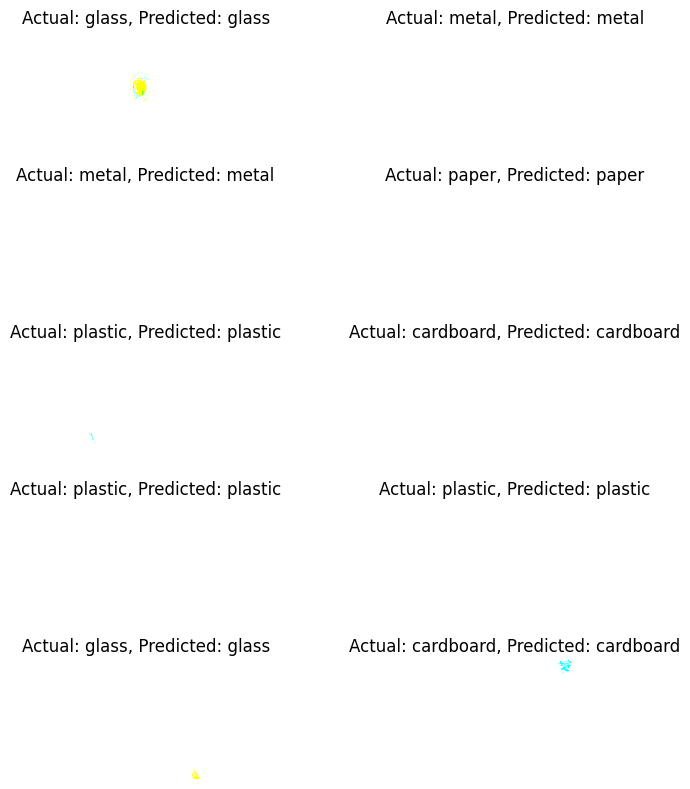

In [82]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


images, labels = next(iter(dataset))


predicted_data = model_vgg19.predict(images)


predicted_labels = np.argmax(predicted_data, axis=-1)


num_images = 10


random_indices = np.random.choice(images.shape[0], num_images, replace=False)


plt.figure(figsize=(10, 8))


for i, idx in enumerate(random_indices):
    actual_class = np.argmax(labels[idx].numpy())
    predicted_class = predicted_labels[idx]

    img = images[idx].numpy()
    img = np.clip(img, 0, 1)

    # Display the image
    plt.subplot(5, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # class labels for actual and predicted classes
    class_names = dataset.class_names

    actual_class_label = class_names[int(actual_class)]
    predicted_class_label = class_names[int(predicted_class)]

    # Set the title with actual and predicted class labels
    plt.title(f"Actual: {actual_class_label}, Predicted: {predicted_class_label}")

# Display the plot
plt.tight_layout()
plt.show()
